# Bayesian Model Free Clustering

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

### サンプルデータの生成

In [2]:
np.random.seed(0)
X_c0 = np.random.multivariate_normal(np.array(( 1,  1)), np.array(((1, -0.8), (-0.8, 1))), size = 100)
X_c1 = np.random.multivariate_normal(np.array((-2, -1)), np.array(((1, -0.8), (-0.8, 1))), size = 100)
X_c2 = np.random.multivariate_normal(np.array(( 0, -1)), np.array(((1, -0.8), (-0.8, 1))), size = 100)
X = np.concatenate([X_c0, X_c1, X_c2])

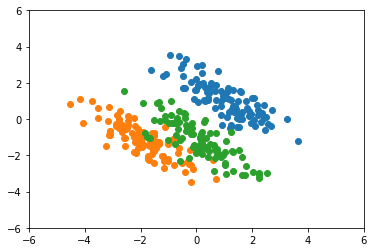

In [3]:
plt.scatter(X_c0[:, 0], X_c0[:, 1])
plt.scatter(X_c1[:, 0], X_c1[:, 1])
plt.scatter(X_c2[:, 0], X_c2[:, 1])
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

---

## Bayesian Model Free Clusteringの実装

In [4]:
class BayesianModelFreeClustering:
    def __init__(
        self,
        num_clusters,
        loss,
        w,
        num_iters_warmup,
        num_iters_sampling,
        num_updating_points = 1,
        random_state = np.random.RandomState(0)
    ):
        self.num_clusters = num_clusters
        self.loss = loss
        self.w = w
        self.num_iters_warmup = num_iters_warmup
        self.num_iters_sampling = num_iters_sampling
        self.num_updating_points = num_updating_points
        self.random_state = random_state

    def fit_transform(self, X):
        num_points = X.shape[0]
        if num_points < self.num_clusters:
            raise Exception("データ数がクラスター数を下回っています。")

        cluster = np.zeros((num_points, self.num_clusters, self.num_iters_warmup + self.num_iters_sampling))
        loss = np.zeros(self.num_iters_warmup + self.num_iters_sampling)

        # MCMC (メトロポリス法)
        for i in tqdm(range(self.num_iters_warmup + self.num_iters_sampling)):
            if i == 0:
                # 初期化
                while np.any(cluster[:, :, 0].sum(axis = 0) == 0):  # データ数0のクラスターが生じた場合はサンプリングし直す
                    cluster[:, :, 0] = np.identity(self.num_clusters)[self.random_state.randint(self.num_clusters, size = num_points)]
                loss[0] = self.loss(X, cluster[:, :, 0])
            else:
                # ランダムサンプリング
                while np.any(cluster[:, :, i].sum(axis = 0) == 0):  # データ数0のクラスターが生じた場合はサンプリングし直す
                    updated_point_indices = self.random_state.choice(num_points, self.num_updating_points, replace = False)
                    cluster[:, :, i] = cluster[:, :, i - 1]
                    cluster[updated_point_indices, :, i] = np.identity(self.num_clusters)[self.random_state.randint(self.num_clusters, size = self.num_updating_points)]
                loss[i] = self.loss(X, cluster[:, :, i])

                # 更新
                #   条件式1：採択率が100%を超える場合は、常に更新する
                #     採択率が100%を超えるか否かの判定式
                #       π(S) * np.exp(-1 * self.w * loss[i - 1]) < π(S) * np.exp(-1 * self.w * loss[i])
                #   条件式2：採択率が100%を下回る場合は、採択率に従って更新する
                #     採択率の計算式
                #       π(S) * np.exp(-1 * self.w * loss[i]) / π(S) * np.exp(-1 * self.w * loss[i - 1])
                if loss[i] < loss[i - 1] or self.random_state.random_sample() < np.exp(-1 * self.w * (loss[i] - loss[i - 1])):
                    pass
                else:
                    cluster[:, :, i] = cluster[:, :, i - 1]
                    loss[i] = loss[i - 1]

        return cluster, loss

---

## 実行例

In [5]:
def se(X, cluster):
    X_mean = (X[:, np.newaxis, :] * cluster[:, :, np.newaxis]).sum(axis = 0) / cluster.sum(axis = 0)[:, np.newaxis]
    loss = (((X[:, np.newaxis, :] - X_mean[np.newaxis, :, :]) * cluster[:, :, np.newaxis]) ** 2).sum()
    return loss

bmfc = BayesianModelFreeClustering(
    num_clusters = 3,
    loss = se,
    w = 1,
    num_iters_warmup = 5000,
    num_iters_sampling = 5000
)

In [6]:
cluster, loss = bmfc.fit_transform(X)
p = cluster[:, :, bmfc.num_iters_warmup:].mean(axis = 2)

  0%|          | 0/10000 [00:00<?, ?it/s]

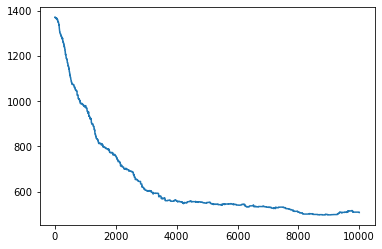

In [7]:
plt.plot(loss)
plt.show()

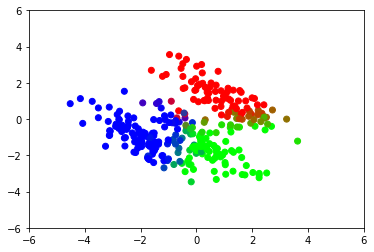

In [8]:
plt.scatter(x = X[:, 0], y = X[:, 1], color = p)
plt.xlim(-6, 6)
plt.ylim(-6, 6)
plt.show()

In [9]:
fig, ax = plt.subplots()
ax.set_xlim(-6, 6)
ax.set_ylim(-6, 6)
ims = []
for i in range(bmfc.num_iters_warmup):
    if i % 100 != 0:
        continue
    a = ax.scatter(x = X[:, 0], y = X[:, 1], color = cluster[:, :, :(i + 1)].mean(axis = 2))
    ims.append([a])
ani = animation.ArtistAnimation(fig, ims, interval = 100)
plt.close(fig)

HTML(ani.to_jshtml())

In [10]:
ani.save("bayesian-model-free-clustering.gif")

MovieWriter ffmpeg unavailable; using Pillow instead.
